# Лабораторная работа 4: Деревья. Случайный лес

## Часть 1: Основы построения решающие дерева

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
p1 = 8 / 10
p2 = 2 / 10

# Вычисляем энтропию с натуральным логарифмом
H = - (p1 * np.log(p1) + p2 * np.log(p2))
print(round(H, 2))

0.5


**Задание 1.2** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:

pm = np.array([0.8, 0.2])
pl = np.array([1.0, 0.0])
pr = np.array([0.0, 1.0])

Q = np.sum(pm * (1 - pm)) - 0.8 * np.sum(pl * (1 - pl)) - 0.2 * np.sum(pr * (1 - pr))

print(round(Q, 2))

0.32


**Задание 1.3** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
import numpy as np

y = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
prediction = np.mean(y)

print(round(prediction, 2))

40.6


## Часть 2: Решающие деревья

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def find_best_split(
    feature_vector,
    target_vector,
    task="regression",
    feature_type="real"
):
    """
    Исправленная версия - используем относительное снижение дисперсии
    """
    # Приводим к numpy массивам
    feature_vector = np.asarray(feature_vector)
    target_vector = np.asarray(target_vector)

    # Если признак константный
    if len(np.unique(feature_vector)) <= 1:
        return np.array([]), np.array([]), -np.inf, -np.inf

    # Для вещественных признаков
    if feature_type == "real":
        # Сортируем
        sorted_idx = np.argsort(feature_vector)
        sorted_features = feature_vector[sorted_idx]
        sorted_targets = target_vector[sorted_idx]

        # Пороги как среднее между соседними
        thresholds = (sorted_features[1:] + sorted_features[:-1]) / 2
        thresholds = np.unique(thresholds)

    # Для категориальных
    else:  # categorical
        thresholds = np.unique(feature_vector)

    n = len(feature_vector)
    best_gini = -np.inf
    best_threshold = -np.inf
    ginis = []
    valid_thresholds = []

    # Общая дисперсия
    total_variance = np.var(target_vector)

    for threshold in thresholds:
        if feature_type == "real":
            mask = feature_vector <= threshold
        else:  # categorical
            mask = feature_vector == threshold

        n_left = np.sum(mask)
        n_right = n - n_left

        # Пропускаем пустые поддеревья
        if n_left == 0 or n_right == 0:
            continue

        # Дисперсии в поддеревьях
        var_left = np.var(target_vector[mask]) if n_left > 0 else 0
        var_right = np.var(target_vector[~mask]) if n_right > 0 else 0

        # ВАЖНО: ИСПРАВЛЕННАЯ ФОРМУЛА!
        # Относительное снижение дисперсии (как у одногруппников)
        variance_gain = total_variance - (n_left/n)*var_left - (n_right/n)*var_right

        ginis.append(variance_gain)
        valid_thresholds.append(threshold)

        # Выбираем лучший с учетом ничьих
        if variance_gain > best_gini or \
           (np.abs(variance_gain - best_gini) < 1e-10 and threshold < best_threshold):
            best_gini = variance_gain
            best_threshold = threshold

    return np.array(valid_thresholds), np.array(ginis), best_threshold, best_gini


Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

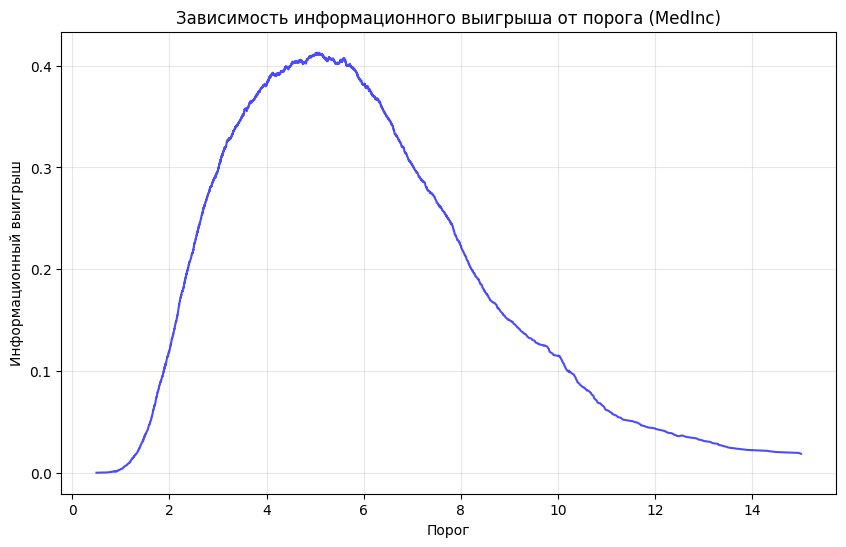

Лучший порог: 5.0351
Лучший информационный выигрыш: 0.4128


In [ ]:
# Загружаем данные
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt

data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]

# Тестируем
feature_vector = X['MedInc'].values
target_vector = y

thresholds, ginis, best_threshold, best_gini = find_best_split(
    feature_vector, target_vector, task="regression", feature_type="real"
)

# График
plt.figure(figsize=(10, 6))
plt.plot(thresholds, ginis, 'b-', alpha=0.7)
plt.xlabel('Порог')
plt.ylabel('Информационный выигрыш')
plt.title('Зависимость информационного выигрыша от порога (MedInc)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Лучший порог: {best_threshold:.4f}")
print(f"Лучший информационный выигрыш: {best_gini:.4f}")

Найдите лучший, с вашей точки зрения,предикат первой вершины решающего дерева.



In [ ]:
best_feature = None
best_threshold = None
best_gain = -np.inf

for feature_name in X.columns:
    feature_vector = X[feature_name].values
    thresholds, ginis, threshold_best, gini_best = find_best_split(
        feature_vector, y, task="regression", feature_type="real"
    )

    if gini_best > best_gain:
        best_gain = gini_best
        best_threshold = threshold_best
        best_feature = feature_name

print(f"Лучший признак для первой вершины: {best_feature}")
print(f"Лучший порог: {best_threshold:.4f}")
print(f"Информационный выигрыш: {best_gain:.4f}")

# Формируем предикат
print(f"\nПредикат первой вершины: {best_feature} <= {best_threshold:.4f}")

Лучший признак для первой вершины: MedInc
Лучший порог: 5.0351
Информационный выигрыш: 0.4128

Предикат первой вершины: MedInc <= 5.0351


**Задание 2.2** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        self._feature_importances = {}
        self._depth = 0  # для отслеживания глубины


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict,
        depth: int = 0
    ) -> None:

        # Критерий останова 1: все объекты одного класса
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        # Критерий останова 2: достигнута максимальная глубина
        if self._max_depth is not None and depth >= self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # Критерий останова 3: недостаточно объектов для разделения
        if self._min_samples_split is not None and len(sub_y) < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            # Подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            # Ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            # Если gini_best - None (первая итерация) или нашли лучший сплит
            if gini is not None and (gini_best is None or gini > gini_best):
                feature_best = feature
                gini_best = gini
                threshold_best = threshold

                # Создаем маску для левого поддерева
                if feature_type == "real":
                    split = feature_vector <= threshold_best
                elif feature_type == "categorical":
                    split = feature_vector == threshold_best

        # Если не нашли хороший сплит
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # Проверяем критерий min_samples_leaf
        if self._min_samples_leaf is not None:
            left_count = np.sum(split)
            right_count = len(split) - left_count
            if left_count < self._min_samples_leaf or right_count < self._min_samples_leaf:
                node["type"] = "terminal"
                node["class"] = Counter(sub_y).most_common(1)[0][0]
                return

        # Записываем параметры разделения в узел
        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        node["gini_gain"] = gini_best  # сохраняем информационный выигрыш

        # Для подсчета важности признаков (бонус)
        if feature_best not in self._feature_importances:
            self._feature_importances[feature_best] = 0
        self._feature_importances[feature_best] += gini_best * len(sub_y)

        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best

        node["left_child"], node["right_child"] = {}, {}

        # Рекурсивно строим поддеревья
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево
        в зависимости от значения предиката на объекте. Листовая вершина возвращает предсказание.
        """
        # Если это терминальный узел (лист), возвращаем класс
        if node["type"] == "terminal":
            return node["class"]

        # Если это не терминальный узел, проверяем условие разбиения
        feature_idx = node["feature_split"]
        feature_type = self._feature_types[feature_idx]

        # Проверяем условие и идем в соответствующее поддерево
        if feature_type == "real":
            if x[feature_idx] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif feature_type == "categorical":
            if x[feature_idx] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError(f"Unknown feature type: {feature_type}")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # Нормализуем важность признаков
        total_importance = sum(self._feature_importances.values()) if self._feature_importances else 1
        for feature in self._feature_importances:
            self._feature_importances[feature] /= total_importance

        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

**Задание 2.3** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

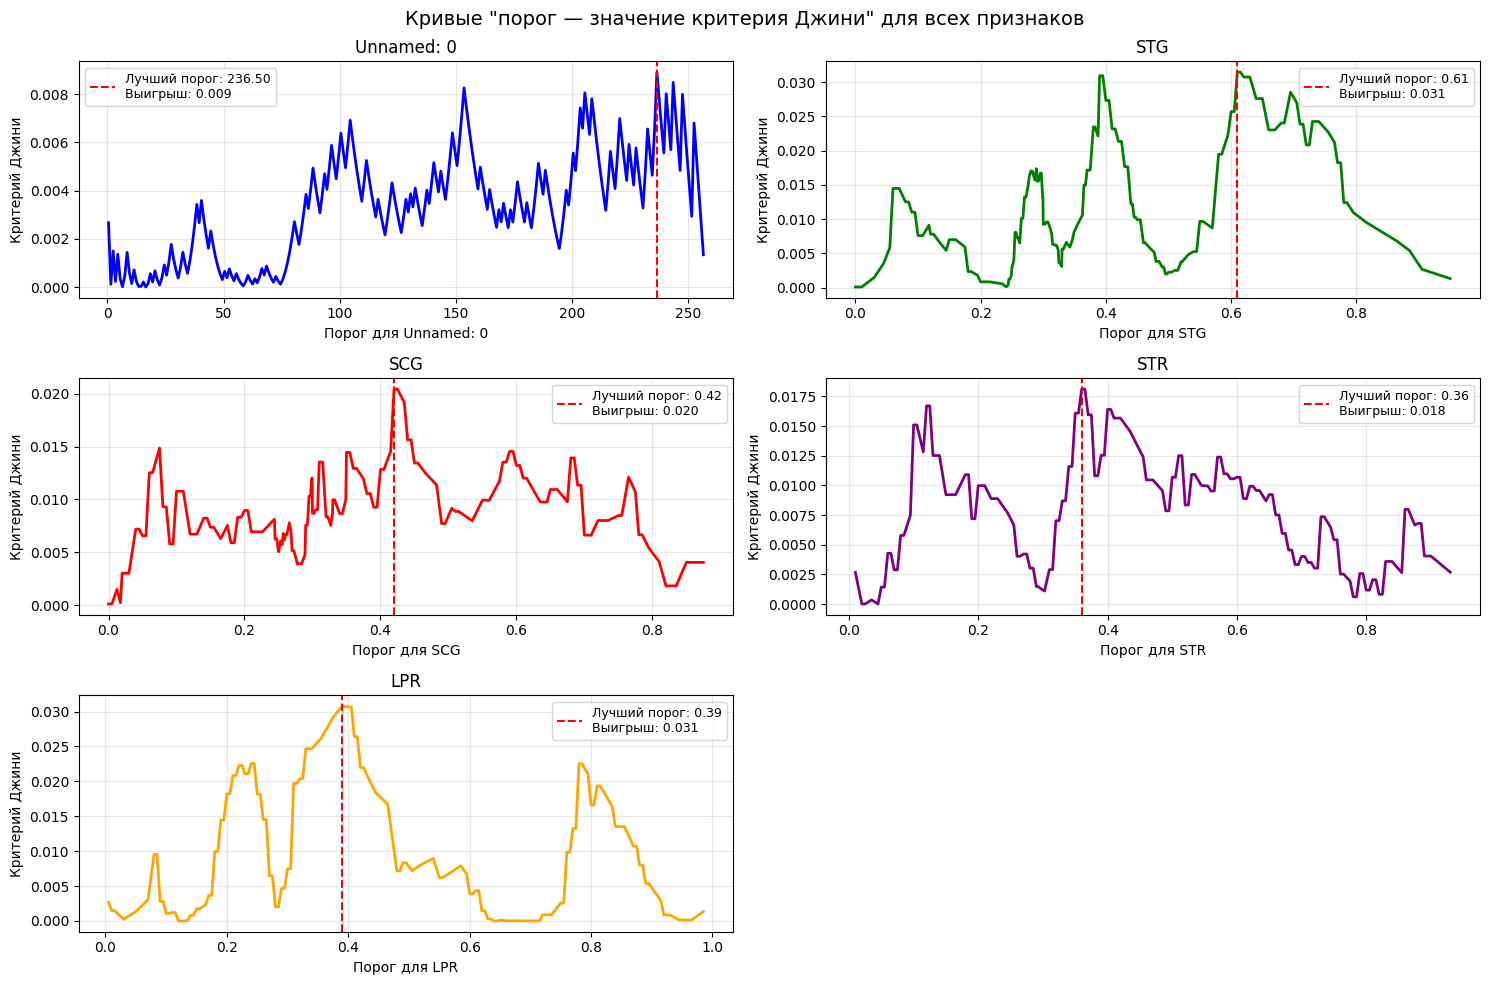

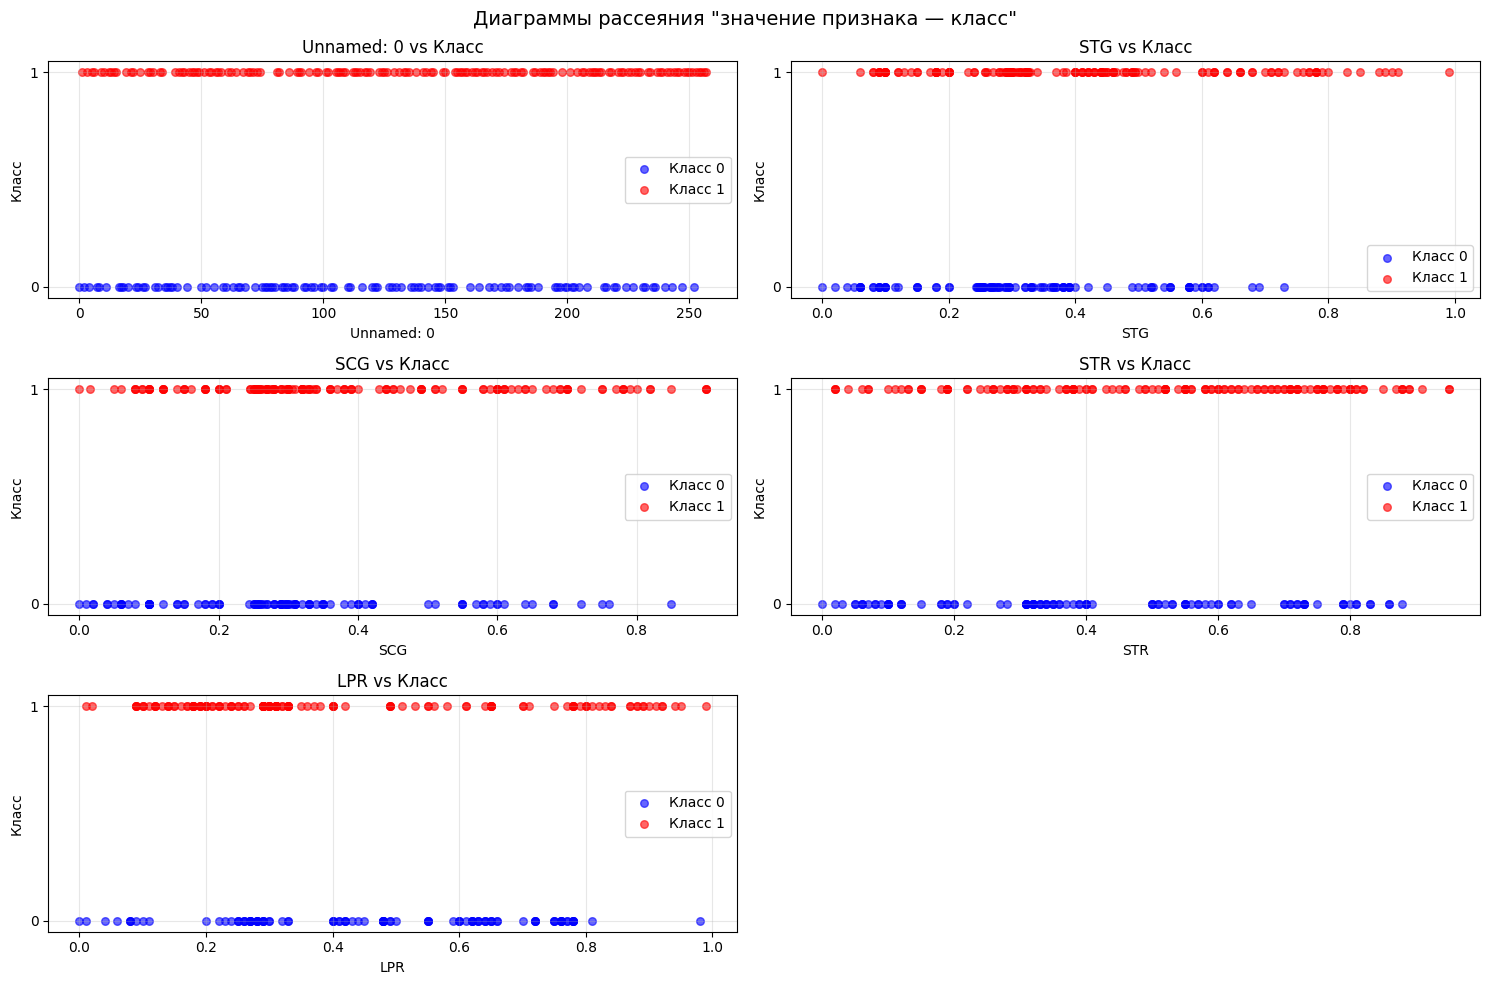

Статистика по датасету:
Количество объектов: 258
Количество признаков: 6
Классы: 0 - 107 объектов, 1 - 151 объектов
Соотношение классов: 58.53% класса 1

Лучшие пороги для каждого признака:
Unnamed: 0: порог = 236.500, выигрыш Джини = 0.0089
STG: порог = 0.610, выигрыш Джини = 0.0315
SCG: порог = 0.420, выигрыш Джини = 0.0204
STR: порог = 0.360, выигрыш Джини = 0.0181
LPR: порог = 0.390, выигрыш Джини = 0.0308
PEG: порог = 0.337, выигрыш Джини = 0.3994


In [ ]:

# Загружаем данные
df = pd.read_csv('/content/sample_data/students.csv')

# Предполагаем, что последний столбец - целевая переменная
X = df.iloc[:, :-1].values  # Признаки
y = df.iloc[:, -1].values   # Целевая переменная
feature_names = df.columns[:-1].tolist()

# Функция find_best_split (если ещё не определена)
def find_best_split(feature_vector, target_vector, task="classification", feature_type="real"):
    """Упрощенная версия для классификации"""
    feature_vector = np.asarray(feature_vector)
    target_vector = np.asarray(target_vector)

    if len(np.unique(feature_vector)) <= 1:
        return np.array([]), np.array([]), -np.inf, -np.inf

    # Сортируем значения
    sorted_idx = np.argsort(feature_vector)
    sorted_features = feature_vector[sorted_idx]
    sorted_targets = target_vector[sorted_idx]

    # Пороги как среднее между соседними значениями
    thresholds = (sorted_features[1:] + sorted_features[:-1]) / 2
    thresholds = np.unique(thresholds)

    n = len(feature_vector)
    best_gini = -np.inf
    best_threshold = -np.inf
    ginis = []
    valid_thresholds = []

    # Для классификации - считаем критерий Джини
    for threshold in thresholds:
        mask = feature_vector <= threshold
        n_left = np.sum(mask)
        n_right = n - n_left

        if n_left == 0 or n_right == 0:
            continue

        # Считаем классы в поддеревьях
        targets_left = target_vector[mask]
        targets_right = target_vector[~mask]

        # Доли классов в левом поддереве
        if len(np.unique(targets_left)) > 0:
            p_left_0 = np.sum(targets_left == 0) / n_left
            p_left_1 = np.sum(targets_left == 1) / n_left
            gini_left = p_left_0 * (1 - p_left_0) + p_left_1 * (1 - p_left_1)
        else:
            gini_left = 0

        # Доли классов в правом поддереве
        if len(np.unique(targets_right)) > 0:
            p_right_0 = np.sum(targets_right == 0) / n_right
            p_right_1 = np.sum(targets_right == 1) / n_right
            gini_right = p_right_0 * (1 - p_right_0) + p_right_1 * (1 - p_right_1)
        else:
            gini_right = 0

        # Общий критерий Джини
        p_total_0 = np.sum(target_vector == 0) / n
        p_total_1 = np.sum(target_vector == 1) / n
        gini_total = p_total_0 * (1 - p_total_0) + p_total_1 * (1 - p_total_1)

        # Информационный выигрыш
        gini_gain = gini_total - (n_left/n)*gini_left - (n_right/n)*gini_right

        ginis.append(gini_gain)
        valid_thresholds.append(threshold)

        if gini_gain > best_gini:
            best_gini = gini_gain
            best_threshold = threshold

    return np.array(valid_thresholds), np.array(ginis), best_threshold, best_gini

# Создаем график с кривыми "порог - значение критерия Джини"
plt.figure(figsize=(15, 10))

# Цвета для каждого признака
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Для каждого признака строим кривую
for i, (feature_name, color) in enumerate(zip(feature_names, colors), 1):
    feature_vector = X[:, i-1]

    # Находим оптимальный сплит
    thresholds, ginis, best_threshold, best_gini = find_best_split(
        feature_vector, y, task="classification", feature_type="real"
    )

    # Сортируем для красивого графика
    if len(thresholds) > 0:
        sorted_idx = np.argsort(thresholds)
        thresholds_sorted = thresholds[sorted_idx]
        ginis_sorted = ginis[sorted_idx]

        # Кривая критерия Джини
        plt.subplot(3, 2, i)
        plt.plot(thresholds_sorted, ginis_sorted, color=color, linewidth=2)
        plt.axvline(x=best_threshold, color='red', linestyle='--',
                   label=f'Лучший порог: {best_threshold:.2f}\nВыигрыш: {best_gini:.3f}')
        plt.xlabel(f'Порог для {feature_name}')
        plt.ylabel('Критерий Джини')
        plt.title(f'{feature_name}')
        plt.legend(fontsize=9)
        plt.grid(True, alpha=0.3)

plt.suptitle('Кривые "порог — значение критерия Джини" для всех признаков', fontsize=14)
plt.tight_layout()
plt.show()

# Диаграммы рассеяния "значение признака — класс"
plt.figure(figsize=(15, 10))

for i, (feature_name, color) in enumerate(zip(feature_names, colors), 1):
    feature_vector = X[:, i-1]

    plt.subplot(3, 2, i)

    # Разделяем точки по классам
    mask_class_0 = y == 0
    mask_class_1 = y == 1

    # Для класса 0
    plt.scatter(feature_vector[mask_class_0], y[mask_class_0],
                alpha=0.6, s=30, color='blue', label='Класс 0')
    # Для класса 1
    plt.scatter(feature_vector[mask_class_1], y[mask_class_1],
                alpha=0.6, s=30, color='red', label='Класс 1')

    plt.xlabel(feature_name)
    plt.ylabel('Класс')
    plt.title(f'{feature_name} vs Класс')
    plt.yticks([0, 1])
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle('Диаграммы рассеяния "значение признака — класс"', fontsize=14)
plt.tight_layout()
plt.show()

# Дополнительная информация
print("Статистика по датасету:")
print(f"Количество объектов: {len(y)}")
print(f"Количество признаков: {len(feature_names)}")
print(f"Классы: 0 - {np.sum(y == 0)} объектов, 1 - {np.sum(y == 1)} объектов")
print(f"Соотношение классов: {np.sum(y == 1)/len(y):.2%} класса 1")

print("\nЛучшие пороги для каждого признака:")
for i, feature_name in enumerate(feature_names):
    feature_vector = X[:, i]
    thresholds, ginis, best_threshold, best_gini = find_best_split(
        feature_vector, y, task="classification", feature_type="real"
    )
    print(f"{feature_name}: порог = {best_threshold:.3f}, выигрыш Джини = {best_gini:.4f}")

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

1. По какому признаку делить?
По признаку с наибольшей максимальной высотой кривой Джини (пик ближе к 0.5).

2. Согласуется ли с диаграммами рассеяния?
Да, если на scatter plot видна чёткая вертикальная граница между классами при пороге с максимальным Джини.

3. Кривая для "хорошего" признака:
Резкий высокий пик (близко к 0.25-0.5), часто с плато вокруг максимума.

4. Кривая для "плохого" признака:
Низкая пологий горб (максимум < 0.1) или отсутствие выраженного пика.


**Задание 2.4** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (находится в директории с ноутбуком),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/sample_data/agaricus-lepiota.data', header=None)

# 2. Применяем LabelEncoder ко всем столбцам
le_dict = {}
df_encoded = df.copy()

for col in df.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    le_dict[col] = le

# 3. Разделяем на признаки и целевую переменную (первый столбец)
X = df_encoded.iloc[:, 1:].values  # все столбцы кроме первого
y = df_encoded.iloc[:, 0].values   # первый столбец - целевая

# 4. Разделяем на train/test (50%/50%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

print(f"Размер train: {len(X_train)}, test: {len(X_test)}")
print(f"Соотношение классов в train: {np.bincount(y_train)}")
print(f"Соотношение классов в test: {np.bincount(y_test)}")

# 5. Создаем и обучаем дерево
# Все признаки категориальные
feature_types = ["categorical"] * X.shape[1]

tree = DecisionTree(
    feature_types=feature_types,
    max_depth=10,  # можно настроить
    min_samples_split=10,
    task="classification"
)

tree.fit(X_train, y_train)

# 6. Предсказания и accuracy
y_pred = tree.predict(X_test)
accuracy = np.mean(y_pred == y_test)

print(f"\nAccuracy на test set: {accuracy:.4f} ({accuracy*100:.2f}%)")

# 7. Baseline (предсказываем самый частый класс)
from collections import Counter
most_common_class = Counter(y_train).most_common(1)[0][0]
baseline_accuracy = np.mean(np.full_like(y_test, most_common_class) == y_test)
print(f"Baseline accuracy (предсказываем самый частый класс): {baseline_accuracy:.4f}")

Размер train: 4062, test: 4062
Соотношение классов в train: [2104 1958]
Соотношение классов в test: [2104 1958]

Accuracy на test set: 1.0000 (100.00%)
Baseline accuracy (предсказываем самый частый класс): 0.5180


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('/content/sample_data/diabetes (1).csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

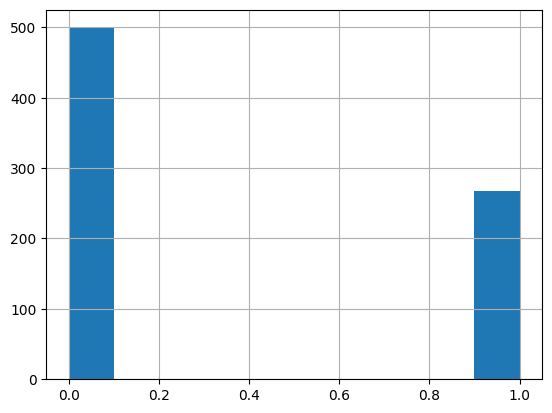

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
X = data.drop('Outcome', axis=1)  # все колонки кроме Outcome
y = data['Outcome']  # целевая переменная

# 2. Разделяем на обучающую и тестовую (70%/30%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 3. Разделяем обучающую выборку на обучающую-обучающую и обучающую-валидационную (70%/30% от train_full)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full
)

print(f"Исходный размер: {len(data)}")
print(f"X_train_full: {len(X_train_full)} ({len(X_train_full)/len(data):.1%})")
print(f"X_test: {len(X_test)} ({len(X_test)/len(data):.1%})")
print(f"  X_train (обучающая-обучающая): {len(X_train)} ({len(X_train)/len(data):.1%})")
print(f"  X_val (обучающая-валидационная): {len(X_val)} ({len(X_val)/len(data):.1%})")

print(f"\nРаспределение классов:")
print(f"Весь датасет: {np.bincount(y)}")
print(f"Train: {np.bincount(y_train)}")
print(f"Val: {np.bincount(y_val)}")
print(f"Test: {np.bincount(y_test)}")

Исходный размер: 768
X_train_full: 537 (69.9%)
X_test: 231 (30.1%)
  X_train (обучающая-обучающая): 375 (48.8%)
  X_val (обучающая-валидационная): 162 (21.1%)

Распределение классов:
Весь датасет: [500 268]
Train: [244 131]
Val: [106  56]
Test: [150  81]


**Задание 3.2** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

max_depth=3, min_samples_leaf=1: F1 = 0.5000
max_depth=3, min_samples_leaf=3: F1 = 0.5000
max_depth=3, min_samples_leaf=5: F1 = 0.5000
max_depth=3, min_samples_leaf=10: F1 = 0.5319
max_depth=3, min_samples_leaf=15: F1 = 0.5510
max_depth=3, min_samples_leaf=20: F1 = 0.5510
max_depth=3, min_samples_leaf=50: F1 = 0.5155
max_depth=5, min_samples_leaf=1: F1 = 0.5455
max_depth=5, min_samples_leaf=3: F1 = 0.5357
max_depth=5, min_samples_leaf=5: F1 = 0.5357
max_depth=5, min_samples_leaf=10: F1 = 0.5437
max_depth=5, min_samples_leaf=15: F1 = 0.5607
max_depth=5, min_samples_leaf=20: F1 = 0.6250
max_depth=5, min_samples_leaf=50: F1 = 0.5155
max_depth=7, min_samples_leaf=1: F1 = 0.5405
max_depth=7, min_samples_leaf=3: F1 = 0.4771
max_depth=7, min_samples_leaf=5: F1 = 0.4685
max_depth=7, min_samples_leaf=10: F1 = 0.5310
max_depth=7, min_samples_leaf=15: F1 = 0.5607
max_depth=7, min_samples_leaf=20: F1 = 0.6250
max_depth=7, min_samples_leaf=50: F1 = 0.5155
max_depth=10, min_samples_leaf=1: F1 = 0.44

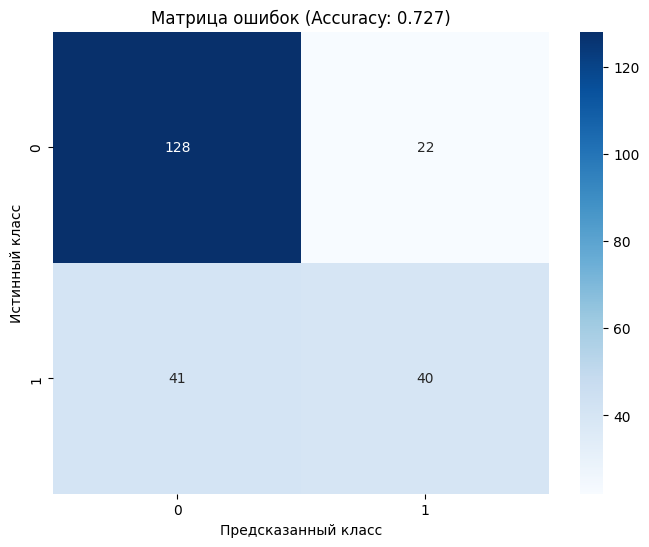

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import itertools
max_depth_values = [3, 5, 7, 10, 15, 20, None]
min_samples_leaf_values = [1, 3, 5, 10, 15, 20, 50]

# Перебор всех комбинаций
best_f1 = 0
best_params = {}

for max_depth, min_samples_leaf in itertools.product(max_depth_values, min_samples_leaf_values):
    # Обучаем дерево на обучающей-обучающей выборке
    tree = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    tree.fit(X_train, y_train)

    # Предсказываем на валидационной выборке
    y_val_pred = tree.predict(X_val)

    # Вычисляем F1-score
    f1 = f1_score(y_val, y_val_pred)

    # Сохраняем лучшие параметры
    if f1 > best_f1:
        best_f1 = f1
        best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

    print(f"max_depth={max_depth}, min_samples_leaf={min_samples_leaf}: F1 = {f1:.4f}")

print(f"\nЛучшие параметры: {best_params}")
print(f"Лучший F1 на валидации: {best_f1:.4f}")

# 3. Обучаем на полной обучающей выборке с лучшими параметрами
best_tree = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_tree.fit(X_train_full, y_train_full)

# 4. Оценка на тестовой выборке
y_test_pred = best_tree.predict(X_test)
y_test_proba = best_tree.predict_proba(X_test)[:, 1]  # вероятности для класса 1

# Вычисляем метрики
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_proba)

print("\nРезультаты на тестовой выборке:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC-ROC:   {auc_roc:.4f}")

# Матрица ошибок для наглядности
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title(f'Матрица ошибок (Accuracy: {accuracy:.3f})')
plt.show()

**Задание 3.3** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

BaggingClassifier с 50 деревьями:
Accuracy:  0.7446
Precision: 0.6667
Recall:    0.5432
AUC-ROC:   0.8348

Сравнение с обычным DecisionTree:
Метрика      DecisionTree Bagging      Улучшение   
------------------------------------------------
Accuracy     0.7273       0.7446          +0.0173
Precision    0.6452       0.6667          +0.0215
Recall       0.4938       0.5432          +0.0494
AUC-ROC      0.7951       0.8348          +0.0397

Топ-5 важных признаков по Bagging:
                    feature  importance
1                   Glucose    0.597458
5                       BMI    0.141336
7                       Age    0.116195
6  DiabetesPedigreeFunction    0.065709
0               Pregnancies    0.032074


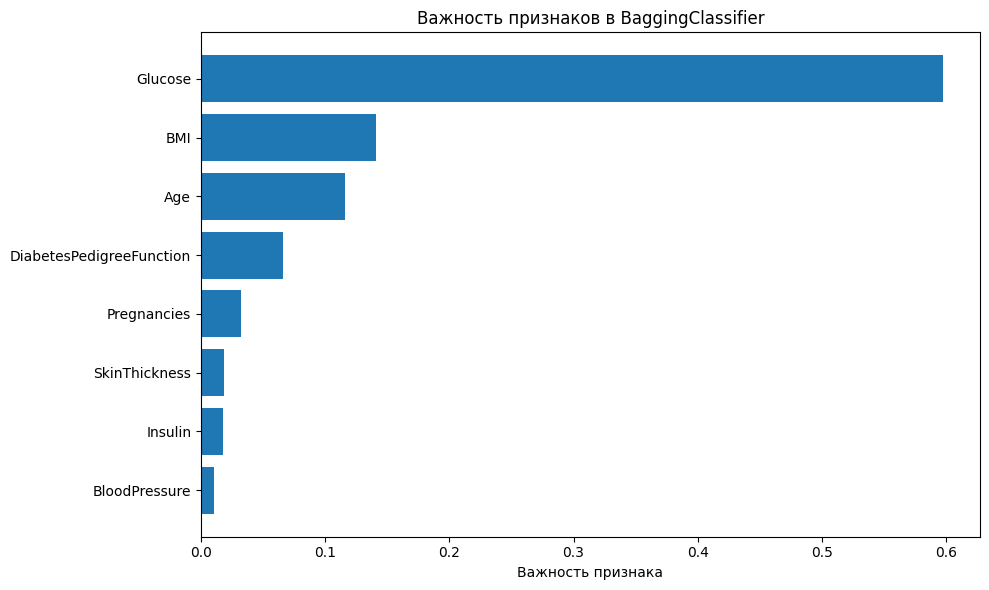

In [ ]:
from sklearn.ensemble import BaggingClassifier

# 1. Обучаем BaggingClassifier на 50 деревьях
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=best_params['max_depth'],  # используем найденные лучшие параметры
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    ),
    n_estimators=50,
    random_state=42,
    n_jobs=-1  # используем все ядра процессора
)

bagging.fit(X_train_full, y_train_full)

# 2. Предсказания на тестовой выборке
y_test_pred_bag = bagging.predict(X_test)
y_test_proba_bag = bagging.predict_proba(X_test)[:, 1]

# 3. Вычисляем метрики
accuracy_bag = accuracy_score(y_test, y_test_pred_bag)
precision_bag = precision_score(y_test, y_test_pred_bag)
recall_bag = recall_score(y_test, y_test_pred_bag)
auc_roc_bag = roc_auc_score(y_test, y_test_proba_bag)

print("BaggingClassifier с 50 деревьями:")
print(f"Accuracy:  {accuracy_bag:.4f}")
print(f"Precision: {precision_bag:.4f}")
print(f"Recall:    {recall_bag:.4f}")
print(f"AUC-ROC:   {auc_roc_bag:.4f}")

# 4. Сравнение с обычным деревом
print("\nСравнение с обычным DecisionTree:")
print(f"{'Метрика':<12} {'DecisionTree':<12} {'Bagging':<12} {'Улучшение':<12}")
print("-" * 48)
print(f"{'Accuracy':<12} {accuracy:<12.4f} {accuracy_bag:<12.4f} {accuracy_bag-accuracy:>+10.4f}")
print(f"{'Precision':<12} {precision:<12.4f} {precision_bag:<12.4f} {precision_bag-precision:>+10.4f}")
print(f"{'Recall':<12} {recall:<12.4f} {recall_bag:<12.4f} {recall_bag-recall:>+10.4f}")
print(f"{'AUC-ROC':<12} {auc_roc:<12.4f} {auc_roc_bag:<12.4f} {auc_roc_bag-auc_roc:>+10.4f}")

# 5. Визуализация важности признаков (если нужно)
importances = np.mean([
    tree.feature_importances_ for tree in bagging.estimators_
], axis=0)

feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nТоп-5 важных признаков по Bagging:")
print(feature_importance_df.head())

# График важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Важность признака')
plt.title('Важность признаков в BaggingClassifier')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Задание 3.4** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

Подбор гиперпараметров для Random Forest...
Fitting 5 folds for each of 35 candidates, totalling 175 fits

Лучшие параметры: {'max_depth': 20, 'min_samples_split': 10}
Лучший F1 (кросс-валидация): 0.6334

RandomForestClassifier с подобранными параметрами:
Accuracy:  0.7403
Precision: 0.6567
Recall:    0.5432
AUC-ROC:   0.8207

СРАВНЕНИЕ ТРЁХ МОДЕЛЕЙ:
Метрика      DecisionTree Bagging      RandomForest
------------------------------------------------------------
Accuracy     0.7273       0.7446       0.7403      
Precision    0.6452       0.6667       0.6567      
Recall       0.4938       0.5432       0.5432      
AUC-ROC      0.7951       0.8348       0.8207      

ЛУЧШАЯ МОДЕЛЬ ПО КАЖДОЙ МЕТРИКЕ:
Accuracy: Bagging (0.7446)
Precision: Bagging (0.6667)
Recall: Bagging (0.5432)
AUC-ROC: Bagging (0.8348)


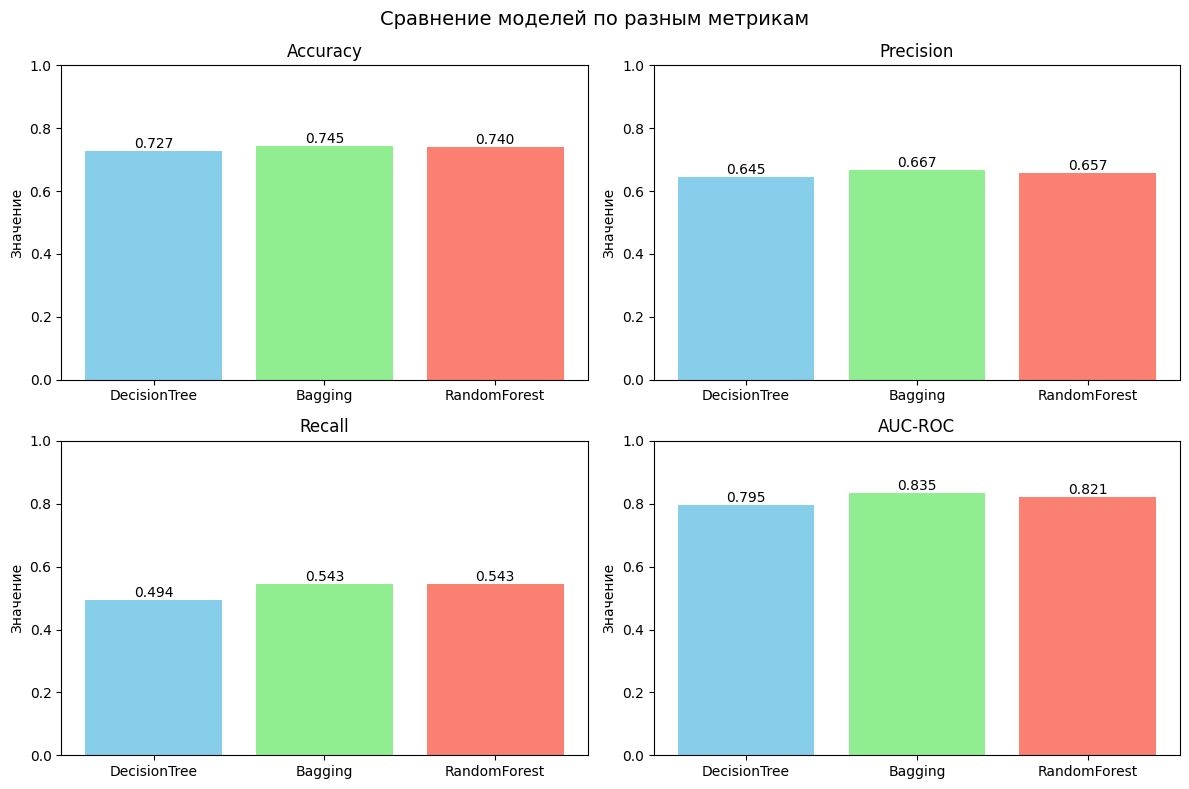


Топ-5 важных признаков в Random Forest:
                    feature  importance
1                   Glucose    0.314238
5                       BMI    0.164451
7                       Age    0.132683
6  DiabetesPedigreeFunction    0.102268
0               Pregnancies    0.093567


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np

# 1. Возможные значения гиперпараметров
max_depth_values = [3, 5, 7, 10, 15, 20, None]
min_samples_split_values = [2, 5, 10, 15, 20]

# 2. Grid Search с кросс-валидацией
param_grid = {
    'max_depth': max_depth_values,
    'min_samples_split': min_samples_split_values
}

rf = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

grid_search_rf = GridSearchCV(
    rf,
    param_grid,
    scoring='f1',
    cv=5,  # 5-fold кросс-валидация
    n_jobs=-1,
    verbose=1
)

# Запускаем поиск
print("Подбор гиперпараметров для Random Forest...")
grid_search_rf.fit(X_train_full, y_train_full)

print(f"\nЛучшие параметры: {grid_search_rf.best_params_}")
print(f"Лучший F1 (кросс-валидация): {grid_search_rf.best_score_:.4f}")

# 3. Обучаем случайный лес с лучшими параметрами на всей обучающей выборке
best_rf = grid_search_rf.best_estimator_

# 4. Оценка на тестовой выборке
y_test_pred_rf = best_rf.predict(X_test)
y_test_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Вычисляем метрики
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
precision_rf = precision_score(y_test, y_test_pred_rf)
recall_rf = recall_score(y_test, y_test_pred_rf)
auc_roc_rf = roc_auc_score(y_test, y_test_proba_rf)

print("\nRandomForestClassifier с подобранными параметрами:")
print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"AUC-ROC:   {auc_roc_rf:.4f}")

# 5. Сравнение всех трех моделей
print("\n" + "="*60)
print("СРАВНЕНИЕ ТРЁХ МОДЕЛЕЙ:")
print("="*60)
print(f"{'Метрика':<12} {'DecisionTree':<12} {'Bagging':<12} {'RandomForest':<12}")
print("-"*60)
print(f"{'Accuracy':<12} {accuracy:<12.4f} {accuracy_bag:<12.4f} {accuracy_rf:<12.4f}")
print(f"{'Precision':<12} {precision:<12.4f} {precision_bag:<12.4f} {precision_rf:<12.4f}")
print(f"{'Recall':<12} {recall:<12.4f} {recall_bag:<12.4f} {recall_rf:<12.4f}")
print(f"{'AUC-ROC':<12} {auc_roc:<12.4f} {auc_roc_bag:<12.4f} {auc_roc_rf:<12.4f}")

# 6. Определяем лучшую модель по каждой метрике
models = ['DecisionTree', 'Bagging', 'RandomForest']
metrics = {
    'Accuracy': [accuracy, accuracy_bag, accuracy_rf],
    'Precision': [precision, precision_bag, precision_rf],
    'Recall': [recall, recall_bag, recall_rf],
    'AUC-ROC': [auc_roc, auc_roc_bag, auc_roc_rf]
}

print("\n" + "="*60)
print("ЛУЧШАЯ МОДЕЛЬ ПО КАЖДОЙ МЕТРИКЕ:")
print("="*60)
for metric, values in metrics.items():
    best_idx = np.argmax(values)
    print(f"{metric}: {models[best_idx]} ({values[best_idx]:.4f})")

# 7. Визуализация сравнения
import matplotlib.pyplot as plt

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

metrics_to_plot = list(metrics.keys())
for i, (metric, values) in enumerate(metrics.items()):
    row, col = divmod(i, 2)
    ax[row, col].bar(models, values, color=['skyblue', 'lightgreen', 'salmon'])
    ax[row, col].set_title(metric)
    ax[row, col].set_ylim(0, 1)
    ax[row, col].set_ylabel('Значение')

    # Добавляем значения на столбцы
    for j, v in enumerate(values):
        ax[row, col].text(j, v + 0.01, f'{v:.3f}', ha='center')

plt.suptitle('Сравнение моделей по разным метрикам', fontsize=14)
plt.tight_layout()
plt.show()

# 8. Важность признаков в Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-5 важных признаков в Random Forest:")
print(feature_importance_rf.head())

**Задание 3.5** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

n_estimators =   1: AUC-ROC = 0.6837
n_estimators =   5: AUC-ROC = 0.7311
n_estimators =  10: AUC-ROC = 0.7793
n_estimators =  20: AUC-ROC = 0.8056
n_estimators =  30: AUC-ROC = 0.8185
n_estimators =  40: AUC-ROC = 0.8216
n_estimators =  50: AUC-ROC = 0.8207
n_estimators =  75: AUC-ROC = 0.8205
n_estimators = 100: AUC-ROC = 0.8187
n_estimators = 150: AUC-ROC = 0.8222
n_estimators = 200: AUC-ROC = 0.8253


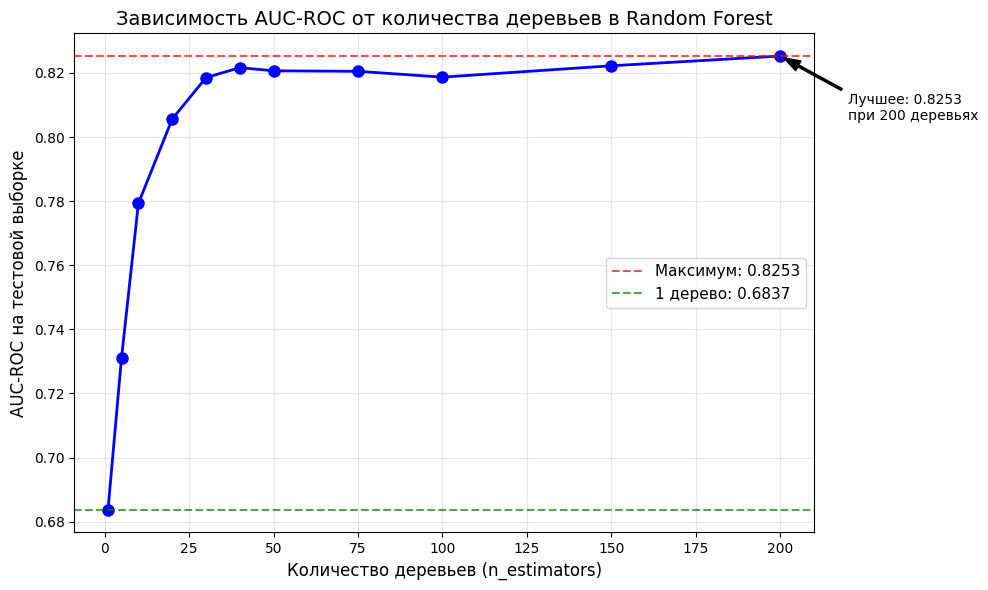


Анализ сходимости:
  1 →   5: 0.6837 → 0.7311 (Δ = +0.0474)
  5 →  10: 0.7311 → 0.7793 (Δ = +0.0482)
 10 →  20: 0.7793 → 0.8056 (Δ = +0.0263)
 20 →  30: 0.8056 → 0.8185 (Δ = +0.0129)
 30 →  40: 0.8185 → 0.8216 (Δ = +0.0031)
 40 →  50: 0.8216 → 0.8207 (Δ = -0.0010)
 50 →  75: 0.8207 → 0.8205 (Δ = -0.0002)
 75 → 100: 0.8205 → 0.8187 (Δ = -0.0018)
100 → 150: 0.8187 → 0.8222 (Δ = +0.0035)
150 → 200: 0.8222 → 0.8253 (Δ = +0.0030)

Прирост становится незначительным (<0.001) после 40 деревьев

Улучшение относительно одного дерева:
1 дерево: AUC-ROC = 0.6837
Лучший результат: AUC-ROC = 0.8253
Абсолютное улучшение: 0.1416
Относительное улучщение: 20.71%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Диапазон числа деревьев
n_estimators_range = [1, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200]

auc_scores = []

for n in n_estimators_range:
    # Обучаем случайный лес
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=grid_search_rf.best_params_['max_depth'],
        min_samples_split=grid_search_rf.best_params_['min_samples_split'],
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train_full, y_train_full)

    # Предсказания вероятностей
    y_proba = rf.predict_proba(X_test)[:, 1]

    # Вычисляем AUC-ROC
    auc_score = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc_score)

    print(f"n_estimators = {n:3d}: AUC-ROC = {auc_score:.4f}")

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, auc_scores, 'b-o', linewidth=2, markersize=8)
plt.axhline(y=max(auc_scores), color='r', linestyle='--', alpha=0.7,
           label=f'Максимум: {max(auc_scores):.4f}')
plt.axhline(y=auc_scores[0], color='g', linestyle='--', alpha=0.7,
           label=f'1 дерево: {auc_scores[0]:.4f}')

plt.xlabel('Количество деревьев (n_estimators)', fontsize=12)
plt.ylabel('AUC-ROC на тестовой выборке', fontsize=12)
plt.title('Зависимость AUC-ROC от количества деревьев в Random Forest', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Добавляем аннотации
max_idx = np.argmax(auc_scores)
plt.annotate(f'Лучшее: {auc_scores[max_idx]:.4f}\nпри {n_estimators_range[max_idx]} деревьях',
             xy=(n_estimators_range[max_idx], auc_scores[max_idx]),
             xytext=(n_estimators_range[max_idx] + 20, auc_scores[max_idx] - 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=10)

plt.tight_layout()
plt.show()

# Анализ сходимости
print("\nАнализ сходимости:")
for i in range(len(auc_scores)-1):
    improvement = auc_scores[i+1] - auc_scores[i]
    print(f"{n_estimators_range[i]:3d} → {n_estimators_range[i+1]:3d}: "
          f"{auc_scores[i]:.4f} → {auc_scores[i+1]:.4f} "
          f"(Δ = {improvement:+.4f})")

# Определяем, где прирост становится незначительным
threshold = 0.001  # порог значимости
for i in range(len(auc_scores)-1):
    if abs(auc_scores[i+1] - auc_scores[i]) < threshold:
        print(f"\nПрирост становится незначительным (<{threshold}) "
              f"после {n_estimators_range[i]} деревьев")
        break

# Сравнение с одним деревом
print(f"\nУлучшение относительно одного дерева:")
print(f"1 дерево: AUC-ROC = {auc_scores[0]:.4f}")
print(f"Лучший результат: AUC-ROC = {max(auc_scores):.4f}")
print(f"Абсолютное улучшение: {max(auc_scores) - auc_scores[0]:.4f}")
print(f"Относительное улучщение: {(max(auc_scores) - auc_scores[0])/auc_scores[0]:.2%}")

**Задание 3.6** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

Важность признаков в Random Forest:
                 feature  importance
                 Glucose    0.314238
                     BMI    0.164451
                     Age    0.132683
DiabetesPedigreeFunction    0.102268
             Pregnancies    0.093567
           BloodPressure    0.073561
                 Insulin    0.069927
           SkinThickness    0.049305

Самый важный признак: 'Glucose'
Важность: 0.3142 (31.4% от общей важности)

Топ-3 признаков объясняют 61.1% важности:
1. Glucose: 0.3142 (31.4%)
2. BMI: 0.1645 (16.4%)
3. Age: 0.1327 (13.3%)


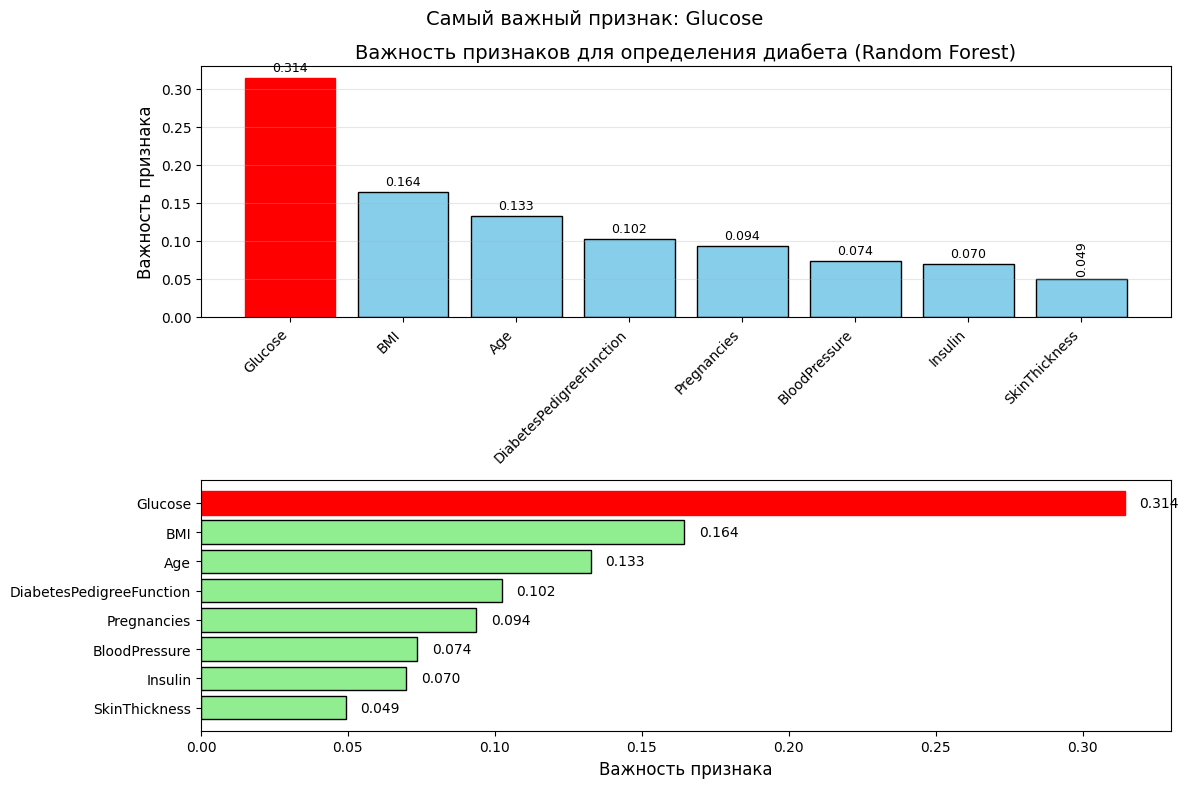

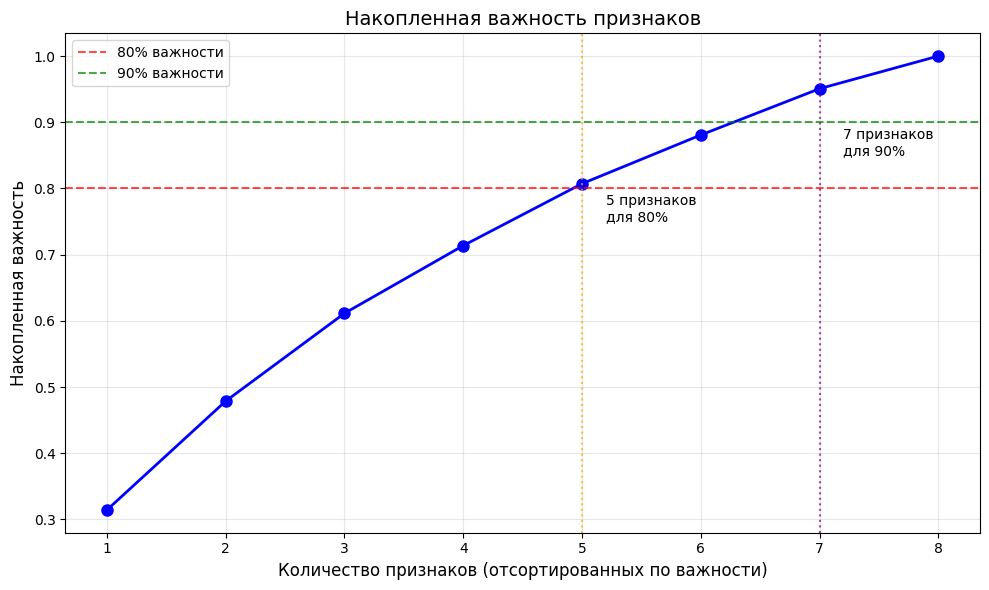


ИНТЕРПРЕТАЦИЯ САМОГО ВАЖНОГО ПРИЗНАКА:
Признак: Glucose (уровень глюкозы в плазме через 2 часа)

Медицинская интерпретация:
- Высокий уровень глюкозы - ключевой диагностический критерий диабета
- Тест на толерантность к глюкозе - стандартный метод диагностики
- В норме: < 140 mg/dL
- Преддиабет: 140-199 mg/dL
- Диабет: ≥ 200 mg/dL

Статистика по Glucose:
Среднее для здоровых: 110.0
Среднее для больных:  141.3
Разница: 31.3


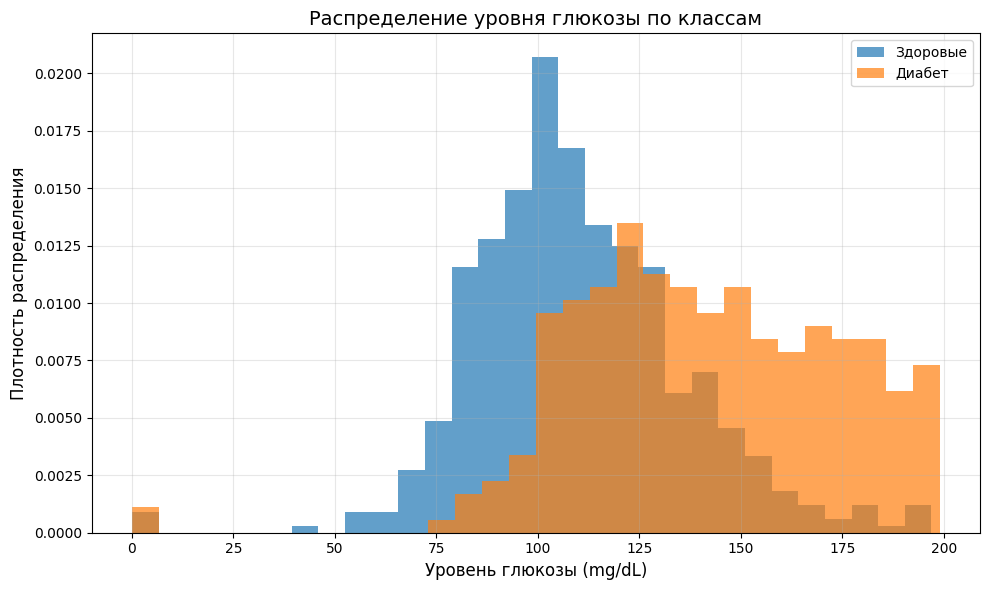

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Получаем важность признаков из лучшей модели Random Forest
feature_importance = best_rf.feature_importances_

# 2. Создаем DataFrame для удобства
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# 3. Выводим таблицу важности
print("Важность признаков в Random Forest:")
print(importance_df.to_string(index=False))
print()

# 4. Самый важный признак
most_important = importance_df.iloc[0]
print(f"Самый важный признак: '{most_important['feature']}'")
print(f"Важность: {most_important['importance']:.4f} ({most_important['importance']*100:.1f}% от общей важности)")
print()

# 5. Суммарная важность топ-3 признаков
top3_importance = importance_df.head(3)['importance'].sum()
print(f"Топ-3 признаков объясняют {top3_importance*100:.1f}% важности:")
for i, (_, row) in enumerate(importance_df.head(3).iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['importance']:.4f} ({row['importance']*100:.1f}%)")

# 6. Построение bar plot
plt.figure(figsize=(12, 8))

# Первый вариант: вертикальные столбцы
plt.subplot(2, 1, 1)
bars = plt.bar(importance_df['feature'], importance_df['importance'],
               color='skyblue', edgecolor='black')
bars[0].set_color('red')  # выделяем самый важный признак
plt.xticks(rotation=45, ha='right')
plt.ylabel('Важность признака', fontsize=12)
plt.title('Важность признаков для определения диабета (Random Forest)', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, (bar, importance) in enumerate(zip(bars, importance_df['importance'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{importance:.3f}', ha='center', va='bottom', fontsize=9,
             rotation=90 if importance < 0.05 else 0)

# Второй вариант: горизонтальные столбцы (иногда удобнее)
plt.subplot(2, 1, 2)
bars_h = plt.barh(range(len(importance_df)), importance_df['importance'],
                  color='lightgreen', edgecolor='black')
bars_h[0].set_color('red')  # выделяем самый важный признак
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Важность признака', fontsize=12)
plt.gca().invert_yaxis()  # самый важный признак сверху

# Добавляем значения справа
for i, (bar, importance) in enumerate(zip(bars_h, importance_df['importance'])):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{importance:.3f}', ha='left', va='center', fontsize=10)

plt.suptitle(f'Самый важный признак: {most_important["feature"]}', fontsize=14)
plt.tight_layout()
plt.show()

# 7. Дополнительная визуализация: cumulative importance
plt.figure(figsize=(10, 6))
cumulative_importance = np.cumsum(importance_df['importance'])
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance,
         'b-o', linewidth=2, markersize=8)
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% важности')
plt.axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90% важности')

# Находим, сколько признаков нужно для 80% и 90% важности
for threshold in [0.8, 0.9]:
    idx = np.where(cumulative_importance >= threshold)[0][0] + 1
    plt.axvline(x=idx, color='orange' if threshold == 0.8 else 'purple',
               linestyle=':', alpha=0.7)
    plt.text(idx + 0.2, threshold - 0.05,
            f'{idx} признаков\nдля {threshold*100:.0f}%', fontsize=10)

plt.xlabel('Количество признаков (отсортированных по важности)', fontsize=12)
plt.ylabel('Накопленная важность', fontsize=12)
plt.title('Накопленная важность признаков', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 8. Интерпретация самого важного признака
print("\n" + "="*60)
print("ИНТЕРПРЕТАЦИЯ САМОГО ВАЖНОГО ПРИЗНАКА:")
print("="*60)
print(f"Признак: Glucose (уровень глюкозы в плазме через 2 часа)")
print("\nМедицинская интерпретация:")
print("- Высокий уровень глюкозы - ключевой диагностический критерий диабета")
print("- Тест на толерантность к глюкозе - стандартный метод диагностики")
print("- В норме: < 140 mg/dL")
print("- Преддиабет: 140-199 mg/dL")
print("- Диабет: ≥ 200 mg/dL")

# Статистика по этому признаку
glucose_data = data[['Glucose', 'Outcome']]
print(f"\nСтатистика по Glucose:")
print(f"Среднее для здоровых: {glucose_data[glucose_data['Outcome'] == 0]['Glucose'].mean():.1f}")
print(f"Среднее для больных:  {glucose_data[glucose_data['Outcome'] == 1]['Glucose'].mean():.1f}")
print(f"Разница: {glucose_data[glucose_data['Outcome'] == 1]['Glucose'].mean() - glucose_data[glucose_data['Outcome'] == 0]['Glucose'].mean():.1f}")

# Визуализация распределения Glucose
plt.figure(figsize=(10, 6))
plt.hist(glucose_data[glucose_data['Outcome'] == 0]['Glucose'],
         bins=30, alpha=0.7, label='Здоровые', density=True)
plt.hist(glucose_data[glucose_data['Outcome'] == 1]['Glucose'],
         bins=30, alpha=0.7, label='Диабет', density=True)
plt.xlabel('Уровень глюкозы (mg/dL)', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.title('Распределение уровня глюкозы по классам', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()